# Predicting Default Payments with Fully-Connected NNs

## Inspecting the Data 

#### Data Dimensionality
- **Training Data Shape**: (25500, 25) indicates that we have 25,500 samples (rows) and 25 features (columns), including the target variable `default payment next month`.
- **Test Data Shape**: (4500, 24) shows that the test data has 4,500 samples and 24 features, excluding the target variable.

#### Data Distribution and Target Variable
- The dataset contains a mix of categorical and numerical variables:
  - **Categorical Variables**: `SEX`, `EDUCATION`, `MARRIAGE` (all encoded as integers).
  - **Numerical Variables**: `LIMIT_BAL`, `AGE`, `PAY_*`, `BILL_AMT*`, `PAY_AMT*`.

#### Target Variable Distribution (from the graph):
- The pie chart shows a clear **class imbalance** in the target variable `default payment next month`. The majority of the samples (77,7%) are labeled as **non-defaults (0)**, while only 22,3% of the samples are labeled as **defaults (1)**.
- This imbalance could affect the model's performance, as it might be biased towards predicting the majority class. 

#### Data Quality
- **Missing Values**: There are no missing values in both the training and test sets, which simplifies the preprocessing step. All columns are fully populated, and no imputation is necessary.
  
#### Descriptive Statistics
- **Numerical Data**:
  - The `LIMIT_BAL` feature has a wide range, from 10,000 to 1,000,000, indicating that different clients have vastly different credit limits.
  - `BILL_AMT*` and `PAY_AMT*` columns show significant variation, with some extremely high values indicating that a small proportion of clients handle very large payments.
  - The `PAY_0` to `PAY_6` columns show that some customers are significantly behind on payments (`PAY_x = 8` means severe delays).
- **Categorical Data**:
  - `SEX` and `MARRIAGE` columns have standard distributions, with most clients being married and slightly more female than male clients (`SEX = 2`).



Training Data Shape: (25500, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25500 entries, 0 to 25499
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          25500 non-null  int64
 1   LIMIT_BAL                   25500 non-null  int64
 2   SEX                         25500 non-null  int64
 3   EDUCATION                   25500 non-null  int64
 4   MARRIAGE                    25500 non-null  int64
 5   AGE                         25500 non-null  int64
 6   PAY_0                       25500 non-null  int64
 7   PAY_2                       25500 non-null  int64
 8   PAY_3                       25500 non-null  int64
 9   PAY_4                       25500 non-null  int64
 10  PAY_5                       25500 non-null  int64
 11  PAY_6                       25500 non-null  int64
 12  BILL_AMT1                   25500 non-null  int64
 13  BILL_AMT2                   

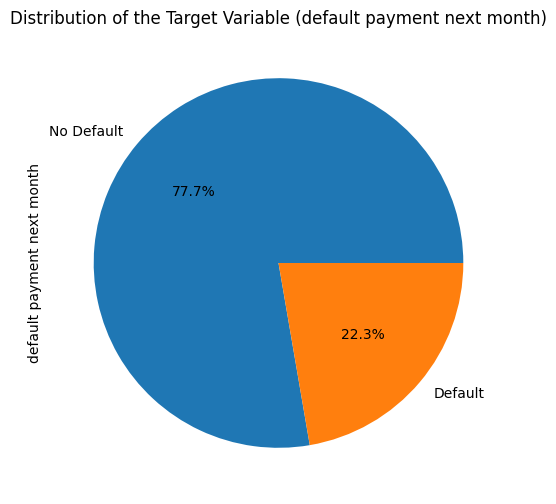

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('./train.csv')

# Inspect the training data
print("Training Data Shape:", train_data.shape)
print("Training Data Info:\n", train_data.info())
print("First Few Rows of Training Data:\n", train_data.head())

# Checking for missing values 
print("Missing values in training data:\n", train_data.isnull().sum())

# Descriptive statistics
print("Training data statistics:\n", train_data.describe())


plt.figure(figsize=(6, 6))
train_data['default payment next month'].value_counts().plot(kind='pie', labels=["No Default", "Default"], autopct='%1.1f%%')
plt.title('Distribution of the Target Variable (default payment next month)')
plt.show()



## Preparing the data

We began by defining the target variable y as the 'default payment next month' column from our dataset. Recognizing that this is a binary classification problem, we converted y into a categorical format using Keras's to_categorical function. This transformation is crucial for neural network models, as it converts class labels into a binary matrix (one-hot encoding), facilitating the modeling of categorical outcomes, the validation set size was increased to 30% to include more instances of Class 1 (defaults). This was done to ensure the model had enough examples of the minority class during validation, helping to better assess its ability to generalize to the less frequent class and potentially improving recall for defaults.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical

df_fr = train_data

# Definition of the features and target variables
y = df_fr['default payment next month']
counts = np.bincount(y)
y = to_categorical(y)
X = df_fr.drop(columns=['default payment next month'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

## Building the network

#### **Network Structure and Layer Choices**

- **Input Layer**:
  - The input layer is defined to match the dimensionality of our feature set. Since X_train.shape[1] gives the number of features, we set the input dimension.

- **Hidden Layers**:
  - We constructed a deep neural network with four hidden layers containing 256, 128, 64, and 32 neurons, respectively. This gradual reduction in the number of neurons that allows the network to learn complex patterns while reducing computational complexity in deeper layers.
  - **Activation Function**: We used the Rectified Linear Unit (ReLU) activation function for all hidden layers. ReLU is widely adopted due to its ability to mitigate the vanishing gradient problem and its computational efficiency.
  - **Batch Normalization Layer**: Before the output layer, we added a BatchNormalization layer. Batch normalization helps in stabilizing and accelerating the training process by normalizing the inputs to each layer, which reduces internal covariate shift.
  
- **Output Layer**:
  - The output layer has a **single neuron** with a **sigmoid activation function**. The sigmoid activation is suitable for binary classification tasks because it outputs a probability value between 0 and 1.


- **Adam Optimizer**:
  - We chose the Stochastic Gradient Descent (SGD) optimizer with a low learning rate of 0.0002. SGD is a fundamental optimizer that performs parameter updates for each training example, and a low learning rate helps in fine-tuning the weights to reach a minimum in the loss function landscape.


- **Binary Crossentropy**:
  -  This is the standard loss function for binary classification problems. It measures the difference between the predicted probability (from the sigmoid output) and the actual class label (0 or 1). Binary crossentropy encourages the model to output values close to the true label probabilities, minimizing the error during training.
  

- **Batch Size**:
  - The model was trained with a **batch size of 128**, which is commonly used in deep learning. This batch size strikes a balance between computational efficiency and stable updates to the model's parameters. Larger batch sizes could reduce the training time, but smaller batch sizes allow for more frequent updates, which can help the model converge better.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Input
from keras.optimizers import SGD
import pandas as pd
import matplotlib.pyplot as plt

dims = X_train.shape[1]
nb_classes = y_train.shape[1]

# Building the neural network model
model = Sequential()
model.add(Input((dims,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

# Output layer with sigmoid activation for binary classification
model.add(Dense(nb_classes, activation='sigmoid'))

# SGD optimizer
optimizer = SGD(learning_rate=0.0002)

# Compiling the model with binary_crossentropy for binary classification
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    X_train, y_train, batch_size=128, epochs=100,
    validation_data=(X_val, y_val)
)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4477 - loss: 0.7982 - val_accuracy: 0.5075 - val_loss: 0.6975
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4780 - loss: 0.7784 - val_accuracy: 0.5114 - val_loss: 0.7061
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4893 - loss: 0.7659 - val_accuracy: 0.5337 - val_loss: 0.7167
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5071 - loss: 0.7516 - val_accuracy: 0.5501 - val_loss: 0.7235
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.7389 - val_accuracy: 0.5631 - val_loss: 0.7240
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5585 - loss: 0.7274 - val_accuracy: 0.5763 - val_loss: 0.7196
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5732 - loss: 0.7197 - val_accuracy: 0.5935 - val_loss: 0.7130
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5986 - loss: 0.7067 - val_accu

## Analyze and comment the training results

The training results are promising, with accuracy around 80% and good generalization on both training and validation sets. The close alignment of training and validation curves suggests no significant overfitting. Loss values for training and validation are close, implying effective optimization without overfitting

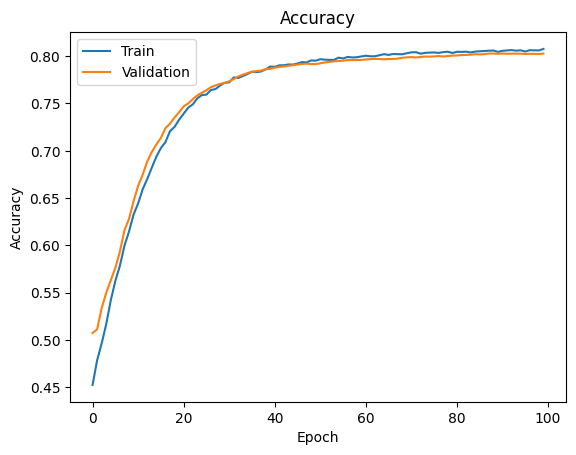

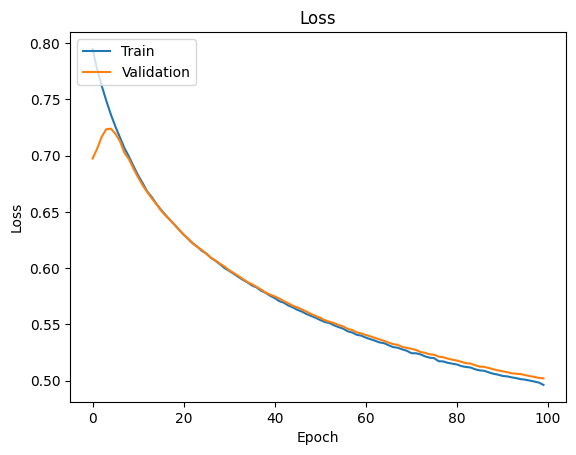

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Validate the model and comment the results

The most suitable performance measures for this dataset are F1-score and AUC-ROC. Since the target variable is binary, F1-score balances precision and recall, which is crucial given the class imbalance.

To evaluate the model, we used several metrics including precision, recall, F1-score, AUC-ROC, and a confusion matrix. 

The model was evaluated on the validation set, achieving an accuracy of 80.27%. However, improvements can still be made, in particular due to the class imbalance.

The confusion matrix shows that the model predicts Class 0 (non-default) with high accuracy, correctly identifying 5,530 of 5,913 instances. However, for Class 1 (default), the model only correctly classifies 611 of 1,737 instances, resulting in lower recall for Class 1. This indicates that the model struggles more with predicting defaults, which is expected given the imbalance between classes.

Precision, Recall, F1-Score: For Class 0, precision, recall, and F1-score are high, reflecting strong performance. For Class 1, precision is 0.61, recall is 0.35, and the F1-score is 0.45, indicating that the model has difficulty correctly identifying defaults.

AUC-ROC: The AUC-ROC score of 0.64 indicates moderate discrimination ability between classes.

The evaluation metrics suggest that the model generalizes reasonably well to the validation set, with no signs of significant overfitting. However, the imbalance between the two classes affects the model's ability to accurately predict Class 1.

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8062 - loss: 0.4992
Valutazione su dati di test - Loss: 0.502054750919342, Accuracy: 0.8027451038360596
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Accuracy: 0.8027450980392157
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      5913
           1       0.61      0.35      0.45      1737

    accuracy                           0.80      7650
   macro avg       0.72      0.64      0.66      7650
weighted avg       0.78      0.80      0.78      7650

AUC-ROC: 0.6434916829432646


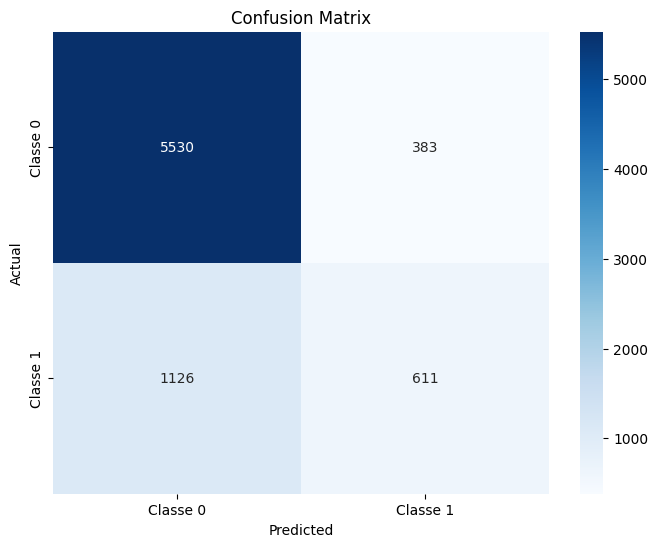

In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Model evaluation
eval = model.evaluate(X_val, y_val)
print(f"Valutazione su dati di test - Loss: {eval[0]}, Accuracy: {eval[1]}")

# Prediction on test data
predictions = model.predict(X_val)

predicted_classes = np.argmax(predictions, axis=1)

y_val_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_val_classes, predicted_classes))
print("Classification Report:")
print(classification_report(y_val_classes, predicted_classes))

auc_roc = roc_auc_score(y_val_classes, predicted_classes, multi_class='ovr')
print(f"AUC-ROC: {auc_roc}")

cm = confusion_matrix(y_val_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and validation phases, my personal expectation is that the model will perform reasonably well on the blind external test set, achieving an accuracy similar to that observed on the validation set, around 80%. However, I expect the model to continue struggling with identifying defaults (Class 1) due to class imbalance, leading to lower recall and F1-scores for this class. Improving the model’s performance on Class 1 may require additional adjustments, such as addressing the class imbalance or fine-tuning the hyperparameters. Despite these challenges, I anticipate that the model's generalization capability will remain consistent, showing no significant signs of overfitting.

In [12]:
X_test = pd.read_csv("./test.csv")

X_test = scaler.transform(X_test)
prediction = model.predict(X_test)
prediction_max = prediction.argmax(axis=-1)

prediction_df = pd.DataFrame(prediction_max)
prediction_df.to_csv('./prediction.csv', index=False, header=False)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
